### Mathematical Idea of AR Model
AR(1) Model (simplest)
𝑌
𝑡
=
𝑐
+
𝜙
1
𝑌
𝑡
−
1
+
𝜀
𝑡
Y
t
	​

=c+ϕ
1
	​

Y
t−1
	​

+ε
t
	​


Where:

𝑌
𝑡
Y
t
	​

 = Reliance stock price today

𝑌
𝑡
−
1
Y
t−1
	​

 = Reliance stock price yesterday

𝑐
c = constant (drift)

𝜙
1
ϕ
1
	​

 = autoregressive coefficient

𝜀
𝑡
ε
t
	​

 = random error (white noise)

📌 Interpretation
If 
𝜙
1
=
0.8
ϕ
1
	​

=0.8, then 80% of yesterday’s price influences today’s price.

AR(p) Model (general case)

AR(p) Model (general case)
𝑌
𝑡
=
𝑐
+
𝜙
1
𝑌
𝑡
−
1
+
𝜙
2
𝑌
𝑡
−
2
+
⋯
+
𝜙
𝑝
𝑌
𝑡
−
𝑝
+
𝜀
𝑡
Y
t
	​

=c+ϕ
1
	​

Y
t−1
	​

+ϕ
2
	​

Y
t−2
	​

+⋯+ϕ
p
	​

Y
t−p
	​

+ε
t
	​


Example:

AR(3) → depends on last 3 days’ prices

In [3]:
# Install once if not available
# pip install yfinance statsmodels scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error



[*********************100%***********************]  1 of 1 completed


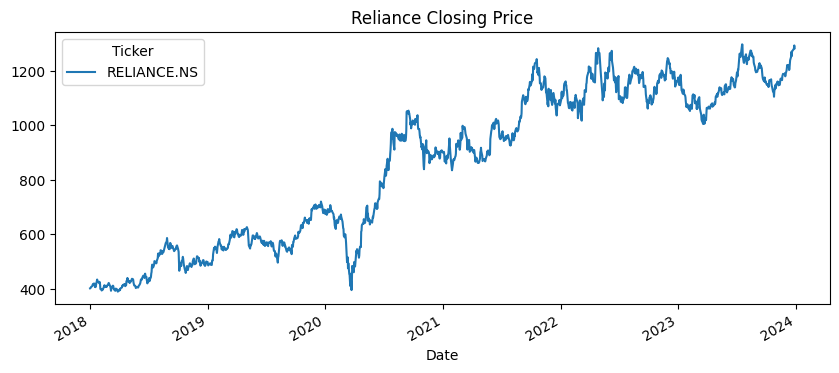

In [4]:
data = yf.download(
    "RELIANCE.NS",
    start="2018-01-01",
    end="2024-01-01"
)

data = data[["Close"]]
data.dropna(inplace=True)

data["Close"].plot(figsize=(10,4), title="Reliance Closing Price")
plt.show()



### convert prices to returns

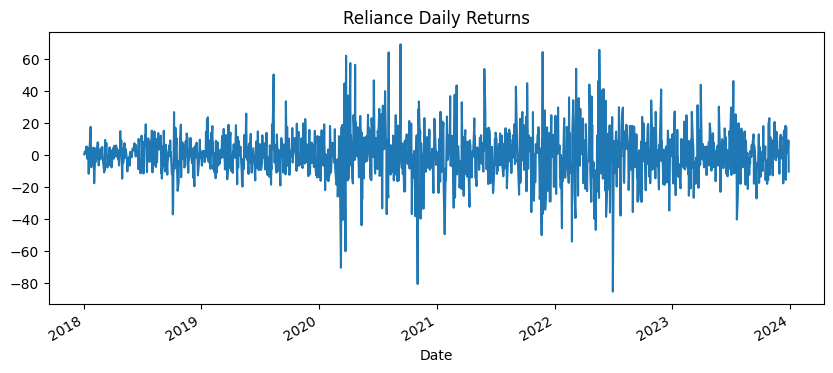

In [6]:
data["Returns"] = data["Close"].diff()
data.dropna(inplace=True)

data["Returns"].plot(figsize=(10,4), title="Reliance Daily Returns")
plt.show()

### Raw prices → non-stationary
Stationarity Test (ADF)

In [7]:
adf_stat, p_value, *_ = adfuller(data["Returns"])

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")


ADF Statistic: -22.820100772384297
p-value: 0.0


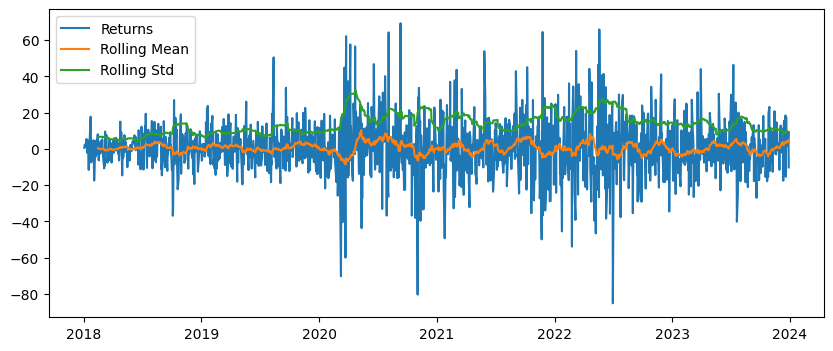

In [15]:
rolling_mean = data["Returns"].rolling(30).mean()
rolling_std = data["Returns"].rolling(30).std()

plt.figure(figsize=(10,4))
plt.plot(data["Returns"], label="Returns")
plt.plot(rolling_mean, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std")
plt.legend()
plt.show()


In [14]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, *_ = kpss(data["Returns"], regression="c")

print("KPSS Statistic:", kpss_stat)
print("p-value:", p_value)
### Interpretation:

## p-value > 0.05 → stationary


KPSS Statistic: 0.02678709774014487
p-value: 0.1


/tmp/ipykernel_11327/3547405763.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, *_ = kpss(data["Returns"], regression="c")


### Train test split

In [8]:
train_size = int(len(data) * 0.8)

train = data["Returns"][:train_size]
test = data["Returns"][train_size:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 1184
Test size: 296


PACF = Partial AutoCorrelation Function

It measures:

Direct relationship between 
𝑌
𝑡
Y
t
	​

 and 
𝑌
𝑡
−
𝑘
Y
t−k
	​

,
after removing effects of intermediate lags

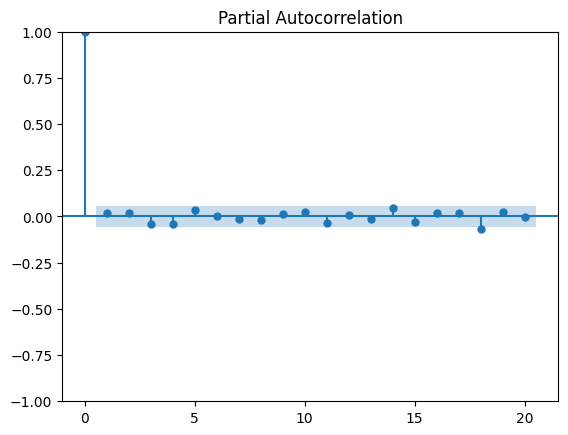

In [9]:
plot_pacf(train, lags=20)
plt.show()


In [10]:
ar_model = AutoReg(train, lags=1).fit()

print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                Returns   No. Observations:                 1184
Model:                     AutoReg(1)   Log Likelihood               -4905.739
Method:               Conditional MLE   S.D. of innovations             15.301
Date:                Fri, 16 Jan 2026   AIC                           9817.477
Time:                        20:32:16   BIC                           9832.704
Sample:                             1   HQIC                          9823.217
                                 1184                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5961      0.445      1.339      0.181      -0.276       1.469
Returns.L1     0.0162      0.029      0.557      0.577      -0.041       0.073
                                    Roots           

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
ar_predictions = ar_model.predict(
    start=len(train),
    end=len(train) + len(test) - 1,
    dynamic=False
)


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


### Model Evaluation Metrics (SAVE THESE)

In [24]:
mae = mean_absolute_error(test, ar_predictions)
rmse = np.sqrt(mean_squared_error(test, ar_predictions))

print("AR Model Performance")
print("MAE :", mae)
print("RMSE:", rmse)


AR Model Performance
MAE : 9.679929956166944
RMSE: 12.768337053544439


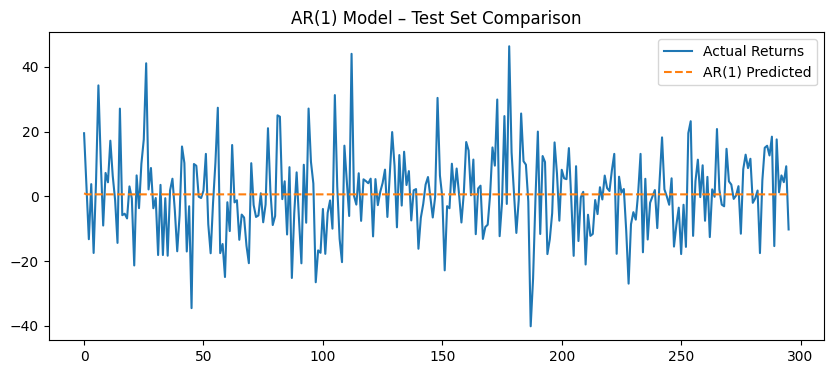

In [25]:
plt.figure(figsize=(10,4))
plt.plot(test.values, label="Actual Returns")
plt.plot(ar_predictions.values, label="AR(1) Predicted", linestyle="--")
plt.legend()
plt.title("AR(1) Model – Test Set Comparison")
plt.show()


### Predicting Actual vs predicted values

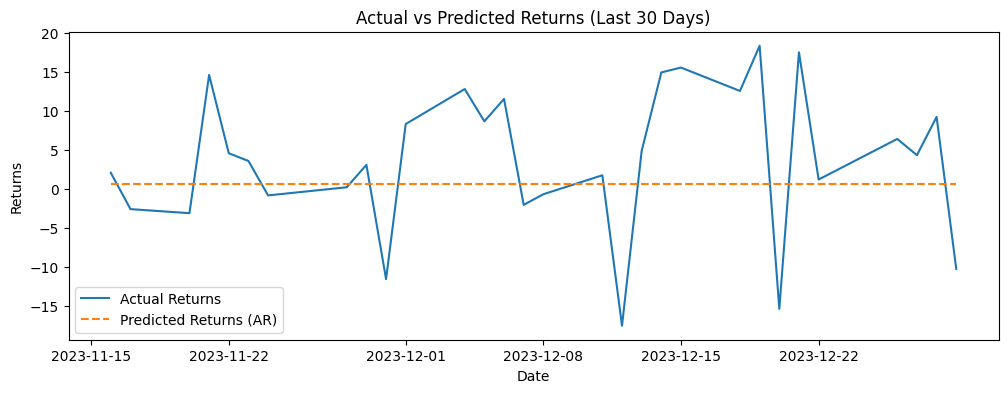

In [26]:
# Fix index
ar_predictions.index = test.index

# Select last 30 days
last_30_actual = test[-30:]
last_30_predicted = predictions[-30:]

plt.figure(figsize=(12,4))
plt.plot(last_30_actual.index, last_30_actual.values, label="Actual Returns")
plt.plot(last_30_predicted.index, last_30_predicted.values,
         label="Predicted Returns (AR)", linestyle="--")

plt.title("Actual vs Predicted Returns (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()


### MA (Moving Average) Model

### ARIMA = AutoRegressive Integrated Moving Average

ARIMA(p,d,q)
ARIMA(p, d, q)
d – Differencing Order (MOST IMPORTANT)
What does d mean?

Number of times you difference the data to make it stationary.
Why is differencing needed?

Stock prices follow random walk:

𝑃
𝑟
𝑖
𝑐
𝑒
𝑡
=
𝑃
𝑟
𝑖
𝑐
𝑒
𝑡
−
1
+
𝜖
𝑡
Price
t
	​

=Price
t−1
	​

+ϵ
t
	​


Differencing removes trend & unit root.

How to choose d?

Use ADF / KPSS

Stop when series becomes stationary

### p – AutoRegressive Order
What does p mean?

Number of past values used to predict current value.

𝑌
𝑡
=
𝜙
1
𝑌
𝑡
−
1
+
𝜙
2
𝑌
𝑡
−
2
+
.
.
.
Y
t
	​

=ϕ
1
	​

Y
t−1
	​

+ϕ
2
	​

Y
t−2
	​

+...

### How to choose p?

📌 Look at PACF plot of differenced series

PACF Behavior	p
Cuts off at lag 1	1
Cuts off at lag 3	3
Gradual decay	AR not dominant

### q – Moving Average Order
What does q mean?

Number of past forecast errors (shocks) used.

𝑌
𝑡
=
𝜖
𝑡
+
𝜃
1
𝜖
𝑡
−
1
+
𝜃
2
𝜖
𝑡
−
2
Y
t
	​

=ϵ
t
	​

+θ
1
	​

ϵ
t−1
	​

+θ
2
	​

ϵ
t−2
	​


| ACF Behavior      | q       |
| ----------------- | ------- |
| Cuts off at lag 1 | 1       |
| Cuts off at lag 2 | 2       |
| Gradual decay     | MA weak |


### Putting It Together (Very Important)

| Model        | Meaning            |
| ------------ | ------------------ |
| ARIMA(1,1,0) | AR on returns      |
| ARIMA(0,1,1) | MA on returns      |
| ARIMA(1,1,1) | AR + MA on returns |
| ARIMA(0,0,0) | White noise        |


p → PACF
d → Stationarity
q → ACF

## MA Model

### MA = Moving Average of past errors (shocks)

Unlike AR:

AR uses past values

MA uses past prediction errors

👉 MA answers:

“How do past shocks affect today?”

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Fit MA(1)
ma_model = ARIMA(train, order=(0, 0, 1)).fit()

print(ma_model.summary())


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 1184
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -4909.391
Date:                Fri, 16 Jan 2026   AIC                           9824.782
Time:                        20:54:37   BIC                           9840.012
Sample:                             0   HQIC                          9830.523
                               - 1184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6058      0.451      1.342      0.180      -0.279       1.491
ma.L1          0.0156      0.025      0.635      0.526      -0.033       0.064
sigma2       233.9252      5.612     41.684      0.0

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
ma_predictions = ma_model.forecast(steps=len(test))

# Align index properly (CRITICAL)
ma_predictions.index = test.index


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [29]:
ar_predictions.index = test.index


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

results = []

# AR metrics
ar_mae = mean_absolute_error(test, ar_predictions)
ar_rmse = np.sqrt(mean_squared_error(test, ar_predictions))

results.append(("AR(1)", ar_mae, ar_rmse))

# MA metrics
ma_mae = mean_absolute_error(test, ma_predictions)
ma_rmse = np.sqrt(mean_squared_error(test, ma_predictions))

results.append(("MA(1)", ma_mae, ma_rmse))

comparison_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE"]
)

print(comparison_df)


   Model       MAE       RMSE
0  AR(1)  9.679930  12.768337
1  MA(1)  9.679999  12.768418


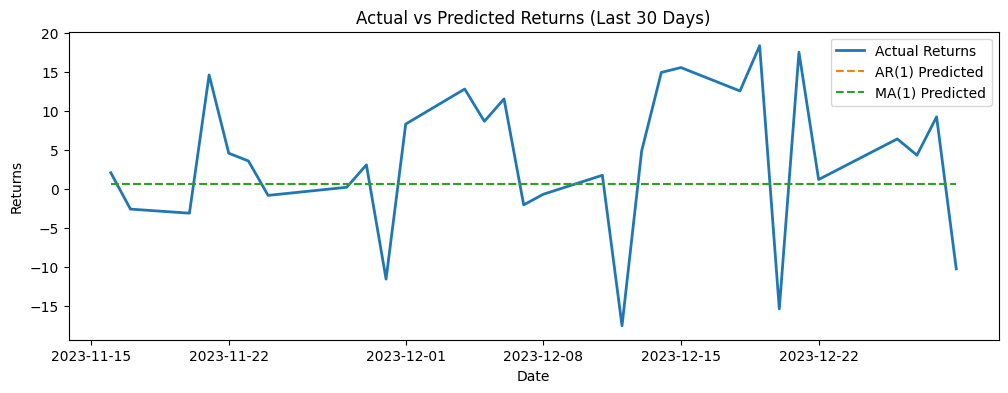

In [31]:
# Last 30 days
actual_30 = test[-30:]
ar_30 = ar_predictions[-30:]
ma_30 = ma_predictions[-30:]

plt.figure(figsize=(12,4))

plt.plot(actual_30.index, actual_30.values, label="Actual Returns", linewidth=2)
plt.plot(ar_30.index, ar_30.values, label="AR(1) Predicted", linestyle="--")
plt.plot(ma_30.index, ma_30.values, label="MA(1) Predicted", linestyle="--")

plt.title("Actual vs Predicted Returns (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()


## ARIMA is designed to:

Model non-stationary series

Capture trend + short memory

Forecast the mean structure

That means:

ARIMA is better applied to PRICES, not returns

### ARIMA(p, d, q) — in ONE sentence

ARIMA = ARMA applied AFTER differencing

d → makes data stationary

p → memory in values

q → memory in shocks

For stocks:

Prices → non-stationary

First difference → stationary

So d = 1

In [32]:
price_series = data["Close"]

train_size = int(len(price_series) * 0.8)
train_price = price_series[:train_size]
test_price = price_series[train_size:]


In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_price, order=(1, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            RELIANCE.NS   No. Observations:                 1184
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4906.817
Date:                Fri, 16 Jan 2026   AIC                           9819.633
Time:                        20:57:31   BIC                           9834.860
Sample:                             0   HQIC                          9825.373
                               - 1184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6350      5.713     -0.111      0.911     -11.833      10.563
ma.L1          0.6368      5.702      0.112      0.911     -10.540      11.813
sigma2       234.5485      5.716     41.034      0.0

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
arima_forecast = arima_fit.forecast(steps=len(test_price))
arima_forecast.index = test_price.index


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


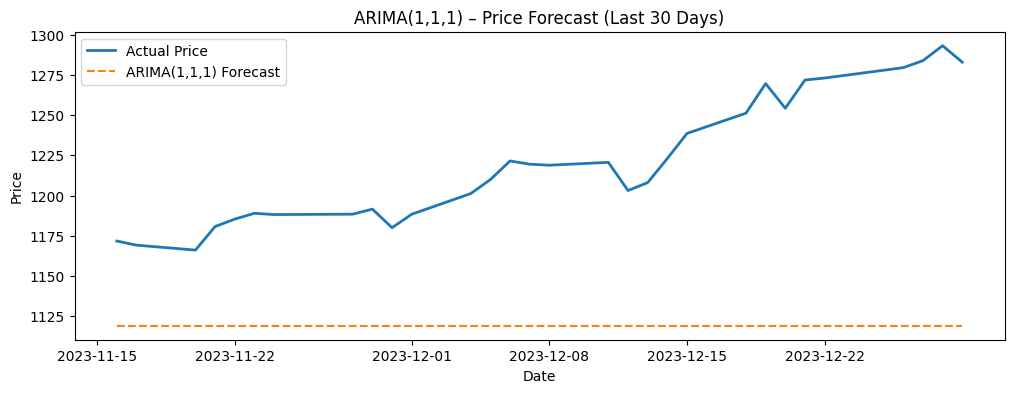

In [35]:
plt.figure(figsize=(12,4))

plt.plot(test_price[-30:], label="Actual Price", linewidth=2)
plt.plot(arima_forecast[-30:], label="ARIMA(1,1,1) Forecast", linestyle="--")

plt.title("ARIMA(1,1,1) – Price Forecast (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
